In [12]:
using PauliPropagation
using Random
using Optim
using Plots
Random.seed!(42)
using ReverseDiff: GradientTape, gradient!, compile

### Functions for QAOA on Ising spin chain
- TFIM with obc
- QAOA circuit
- Parameter assignment function

In [13]:
#QAOA circuit
function tfimqaoacircuit(nqubits::Integer, nlayers::Integer; topology=nothing)
    circuit::Vector{Gate} = []

    if isnothing(topology)
        topology = bricklayertopology(nqubits;periodic=false) #chain with obc
    end

    for i in 1:nlayers
        rzzlayer!(circuit, topology)
        for qubit in 1:nqubits
            push!(circuit, CliffordGate(:S, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2)) # Fig7: P=R_X(π/2)
            push!(circuit, PauliRotation(:Z, qubit))
            push!(circuit, PauliRotation(:X, qubit, π/2))
            push!(circuit, CliffordGate(:S, qubit))

        end
    end
    return circuit
end

tfimqaoacircuit (generic function with 1 method)

In [14]:
#grouped assignment of the params for QAOA circuit
function assign_qaoa_parameters(circuit, nqubits::Integer, nlayers::Integer)
    
    rzz_indices = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    rz_indices = getparameterindices(circuit, PauliRotation, [:Z])

    #group sizes
    Q_minus_1 = (nqubits - 1) * nlayers  # RZZ parameters
    Q = nqubits * nlayers                # RZ parameters

    #group the random values according to circuit layout
    thetas = zeros(maximum(vcat(rzz_indices, rz_indices)))
    thetas[rzz_indices] .= repeat(randn(nlayers), inner=(Q_minus_1 ÷ nlayers))
    thetas[rz_indices] .= repeat(randn(nlayers), inner=(Q ÷ nlayers))

    return thetas
end

assign_qaoa_parameters (generic function with 1 method)

### Initialize circuit
- initial parameters
- define truncations dpending on the method of gradient computation
- for `ReverseDiff`, better to use `max_weight` (number of non-Id in string), `max_freq`, and `max_sins`(number of sins - as in SPD) (see notebook 8)
- define H within loss function

In [15]:
const nq = 16 #we set const for global vars in fcts to opt performance
const nl = 2 #number of layers
const topology = bricklayertopology(nq;periodic=false) #chain with obc  
const g = 2 #paramagnetic phase

2

In [16]:
const circuit = tfimqaoacircuit(nq, nl; topology=topology)
nparams = countparameters(circuit)
println("Number of parameters: ", nparams) 
#generate random parameters
thetas_init = assign_qaoa_parameters(circuit, nq, nl)
println("Parameters: ", thetas)

Number of parameters: 62


Parameters: [0.7883556016042917, 0.7883556016042917, 0.7883556016042917, -2.3318046297412156, -0.4248251162736556, -0.4248251162763018, -2.331804629728866, -1.5707963351956251, -1.5707963282773518, -3.1415926597472, -3.1415926438812867, -3.141592646849144, -6.495168622250073e-9, 9.26175327311074e-9]


In [17]:
#define the truncations
const max_freq = 30
const max_weight = 5 #number of non-Id Paulis in string

5

### Loss function and TFIM

In [18]:
function lossfunction(thetas)
    coefftype = eltype(thetas)

    H = PauliSum(nq, coefftype)
    for qind in 1:nq
        add!(H, :X, qind, coefftype(-g))
    end
    for pair in topology
        add!(H, [:Z, :Z], collect(pair), coefftype(1.0))
    end
    
    wrapped_H = wrapcoefficients(H, PauliFreqTracker) #wrap to keep track of path splitting

    # be also need to run the in-place version with `!`, because by default we copy the Pauli sum
    wrapped_H = propagate!(circuit, wrapped_H, thetas; max_freq, max_weight);
    return overlapwithzero(wrapped_H)
end

lossfunction (generic function with 1 method)

In [19]:
@time lossfunction(thetas_init) #check

  0.662821 seconds (772.37 k allocations: 38.155 MiB, 99.81% compilation time)


-8.940479753015017

In [20]:
### This is following an ReverseDiff.jl example

# some inputs and work buffer to play around with
grad_array_compiled = similar(thetas_init);

# pre-record a GradientTape for `gradsimulation` using inputs of length m with Float64 elements

const simulation_tape = GradientTape(lossfunction, thetas_init)
const compiled_simulation_tape = compile(simulation_tape)
#graph for the chain rule is computed only once! (const)

# first evaluation compiles and is slower
#@time gradient!(grad_array_compiled, compiled_simulation_tape, thetas)
# second evaluation
#@time gradient!(grad_array_compiled, compiled_simulation_tape, thetas);

typename(ReverseDiff.CompiledTape)(lossfunction)

-1.4933530876889995


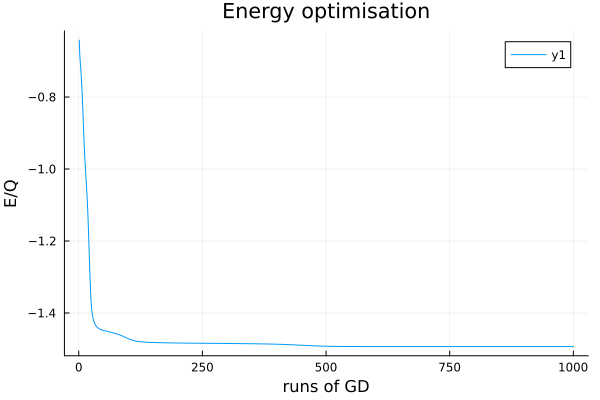

In [ ]:
# gradient descent
eta = 0.1
opt_energy_gd = []
thetas = thetas_init
for i in 1:1000 # steps
    gradient!(grad_array_compiled, simulation_tape, thetas)
    thetas .-= eta * grad_array_compiled
    opt_energy_gd = push!(opt_energy_gd, lossfunction(thetas)/nq)
end
#println(thetas) #Why do the first few stay the same, while the end is strongly modified? Is this sth systematic?
println(lossfunction(thetas)/nq)
plot(opt_energy_gd)

plot!(title = "Energy optimisation", xlabel = "runs of GD", ylabel = "E/Q")

In [ ]:
#ADAM
thetas = thetas_init
opt_energy_adam = []

opt_result = Optim.optimize(lossfunction, thetas, Adam(), Optim.Options(iterations=1000))
thetas .= Optim.minimizer(opt_result)

#println(thetas)  # Check the final optimized parameters
println(lossfunction(thetas)/nq)  # Check the final optimized energy (even worse than GD)


-1.4934222960078287


- We expect an exact energy/qubit of -2.1 approximately for 16 qubits (Fig2)
- Reducing the truncation does not change results significantly.
- Chose a better optimiser than GD, tried ADAM which gives the same result.
- We have (2Q-1) non-Cliffords in the circuit, so N=31 non-Cliffords already (this is quite high for a cl simulation, state of the art is N<80 and Piotr used MPS with up to N=35)
- We want to run PP on a circuit that is near-Clifford.